## Survival analysis proof-of-concept

Much of the preprocessing code is based on: https://github.com/greenelab/mpmp/blob/master/mpmp/utilities/data_utilities.py#L510

In [1]:
from pathlib import Path
import pickle as pkl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

import sys; sys.path.append('..')
import config as cfg

In [2]:
GENE = 'IDH1'
CLASSIFICATION = 'Oncogene'

MPMP_LOCATION = Path('/home/jake/research/mpmp')

### Get clinical endpoint info

In [3]:
# use TCGA clinical data downloaded in mpmp repo
clinical_filename = (
    MPMP_LOCATION / 'data' / 'raw' / 'TCGA-CDR-SupplementalTableS1.xlsx'
)

In [4]:
clinical_df = pd.read_excel(
    clinical_filename,
    sheet_name='TCGA-CDR',
    index_col='bcr_patient_barcode',
    engine='openpyxl'
)

clinical_df.index.rename('patient_id', inplace=True)

# drop numeric index column
clinical_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

# we want to use age as a covariate
clinical_df.rename(columns={'age_at_initial_pathologic_diagnosis': 'age'},
                   inplace=True)

print(clinical_df.shape)
clinical_df.iloc[:5, :5]

(11160, 32)


,type,age,gender,race,ajcc_pathologic_tumor_stage
patient_id,,,,,
TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II
TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV
TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III
TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV
TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III


In [5]:
# we want to use overall survival as the target variable except for
# certain cancer types where progression-free intervals are typically
# used (since very few deaths are observed)
# this is recommended in https://doi.org/10.1016/j.cell.2018.02.052
pfi_cancer_types = [
    'BRCA', 'DLBC', 'LGG', 'PCPG', 'PRAD',
    'READ', 'TGCT', 'THCA', 'THYM'
]

clinical_df['time_in_days'] = clinical_df['OS.time']
clinical_df['status'] = clinical_df['OS'].astype('bool')

pfi_samples = clinical_df.type.isin(pfi_cancer_types)
clinical_df.loc[pfi_samples, 'time_in_days'] = clinical_df[pfi_samples]['PFI.time']
clinical_df.loc[pfi_samples, 'status'] = clinical_df[pfi_samples]['PFI'].astype('bool')

# clean up columns and drop samples with NA survival times
na_survival_times = (clinical_df['time_in_days'].isna())
cols_to_keep = ['status', 'time_in_days', 'age', 'type']
clinical_df = clinical_df.loc[~na_survival_times, cols_to_keep].copy()

# mean impute missing age values
clinical_df.age.fillna(clinical_df.age.mean(), inplace=True)

print(clinical_df.shape)
clinical_df.head()

(11094, 4)


,status,time_in_days,age,type
patient_id,,,,
TCGA-OR-A5J1,True,1355.0,58.0,ACC
TCGA-OR-A5J2,True,1677.0,44.0,ACC
TCGA-OR-A5J3,False,2091.0,23.0,ACC
TCGA-OR-A5J4,True,423.0,23.0,ACC
TCGA-OR-A5J5,True,365.0,30.0,ACC


### Get mutated samples info

TODO: make this into a function(s)

In [6]:
# mutation and copy number data
pancancer_pickle = MPMP_LOCATION / 'data' / 'pancancer_data.pkl'

with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)

In [7]:
# get (binary) mutation data
# 1 = observed non-silent mutation in this gene for this sample, 0 otherwise
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [8]:
# we use the data source and preprocessing code from the pancancer repo, here:
# https://github.com/greenelab/pancancer/blob/d1b3de7fa387d0a44d0a4468b0ac30918ed66886/scripts/initialize/process_copynumber.py#L21

copy_thresh_df = (
    pd.read_csv(cfg.data_dir / 'pancan_GISTIC_threshold.tsv',
                sep='\t', index_col=0)
      .drop(columns=['Locus ID', 'Cytoband'])
)
copy_thresh_df.columns = copy_thresh_df.columns.str[0:15]

# thresholded copy number includes 5 values [-2, -1, 0, 1, 2], which
# correspond to "deep loss", "moderate loss", "no change",
# "moderate gain", and "deep gain", respectively.
print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(25128, 10713)


,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J4-01,TCGA-OR-A5J5-01
Gene Symbol,,,,,
ACAP3,0,0,0,1,0
ACTRT2,0,0,0,1,0
AGRN,0,0,0,1,0
ANKRD65,0,0,0,1,0
ATAD3A,0,0,0,1,0


In [9]:
sample_freeze_df = pancancer_data[0]
copy_samples = list(
    set(sample_freeze_df.SAMPLE_BARCODE)
    .intersection(set(copy_thresh_df.columns))
)
print(len(copy_samples))

9068


In [10]:
# make sure we're not losing too many samples, a few is fine
print(sorted(set(sample_freeze_df.SAMPLE_BARCODE) - set(copy_thresh_df.columns)))

['TCGA-06-0152-02', 'TCGA-06-0171-02', 'TCGA-06-0221-02', 'TCGA-14-0736-02', 'TCGA-ER-A19T-01', 'TCGA-ER-A2NF-01']


In [11]:
copy_thresh_df = (copy_thresh_df
    .T
    .loc[sorted(copy_samples)]
    .fillna(0)
    .astype(int)
)

print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,-1,-1,-1,-1,-1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [12]:
# here, we want to use "moderate" and "deep" loss/gain to define CNV
# loss/gain (to match Park et al.)
#
# note that this is different to the more conservative approach of using
# "deep loss/gain" only as in our classifiers

copy_loss_df = (copy_thresh_df
    .replace(to_replace=[1, 2], value=0)
    .replace(to_replace=[-1, -2], value=1)
)
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,1,1,1,1,1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [13]:
copy_gain_df = (copy_thresh_df
    .replace(to_replace=[-1, -2], value=0)
    .replace(to_replace=[1, 2], value=1)
)
print(copy_gain_df.shape)
copy_gain_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### Compare and visualize survival groups

In [14]:
# get mutation info for target gene
if CLASSIFICATION == 'Oncogene':
    binary_mutation_df = (
        mutation_df.loc[:, GENE] | copy_gain_df.loc[:, GENE]
    ).astype(int)
elif CLASSIFICATION == 'TSG':
    binary_mutation_df = (
        mutation_df.loc[:, GENE] | copy_loss_df.loc[:, GENE]
    ).astype(int)
else:
    binary_mutation_df = mutation_df.loc[:, GENE]
    
# get patient ID from sample IDs
binary_mutation_df.index = binary_mutation_df.index.str[:12]

binary_mutation_df.head()

TCGA-02-0047    0
TCGA-02-0055    0
TCGA-02-2483    1
TCGA-02-2485    0
TCGA-02-2486    0
Name: IDH1, dtype: int64

In [15]:
# join survival and mutation info
cancer_types = ['LGG', 'GBM']

surv_groups_df = (clinical_df
    .merge(binary_mutation_df, left_index=True, right_index=True)                 
    .rename(columns={GENE: '{}_is_mutated'.format(GENE)})
    .query('type == @cancer_types')
)

print(surv_groups_df.shape)
surv_groups_df.head()

(628, 5)


,status,time_in_days,age,type,IDH1_is_mutated
TCGA-02-0047,True,448.0,78.0,GBM,0
TCGA-02-0055,True,76.0,62.0,GBM,0
TCGA-02-2483,False,466.0,43.0,GBM,1
TCGA-02-2485,False,470.0,53.0,GBM,0
TCGA-02-2486,True,618.0,64.0,GBM,0


chisq = 145.8957 p = 1.3682e-33


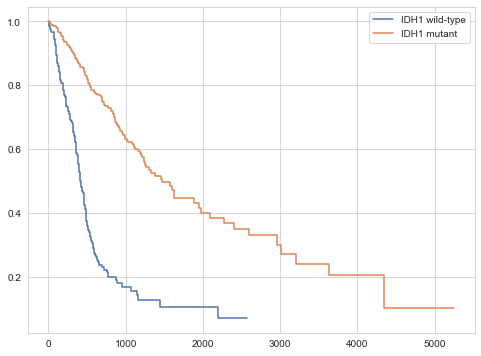

In [16]:
# plot groups
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

mut_col = '{}_is_mutated'.format(GENE)

for is_mutated in surv_groups_df[mut_col].unique():
    mask_mutated = (surv_groups_df[mut_col] == is_mutated)
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        surv_groups_df['status'][mask_mutated],
        surv_groups_df['time_in_days'][mask_mutated]
    )
    
    # TODO: confidence intervals
    label = '{} mutant'.format(GENE) if is_mutated else '{} wild-type'.format(GENE)
    plt.step(time_treatment, survival_prob_treatment, where="post", label=label)
    
plt.legend()
    
# hypothesis testing using log-rank test
y = Surv.from_dataframe('status', 'time_in_days', surv_groups_df)
chisq, p_val = compare_survival(y, surv_groups_df[mut_col].values)
print('chisq = {:.4f}'.format(chisq), 'p = {:.4e}'.format(p_val))